In [ ]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import holidays
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import OptimizeResult
from scipy.optimize import minimize

In [ ]:
''' catBoost '''
!pip install catboost --quiet
from catboost import CatBoostRegressor

     |████████████████████████████████| 76.1 MB 1.3 MB/s 


In [ ]:
''' models '''
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import Ridge, LinearRegression, BayesianRidge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor

from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor

from sklearn.neural_network import MLPRegressor

In [ ]:
''' error '''
from sklearn.metrics import mean_squared_log_error 

In [ ]:
from keras import Sequential

In [ ]:
df_top = pd.read_csv("/content/drive/MyDrive/datasets/tabular jan 22/blending_15-2(mean).csv")

## Загрузка данных

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/datasets/tabular jan 22/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/datasets/tabular jan 22/test.csv")

In [ ]:
df_test['num_sold'] = df_top.num_sold

In [ ]:
df_test.head()

,row_id,date,country,store,tovar,num_sold
0,26298,2019-01-01,Finland,KaggleMart,Kaggle Mug,377.771227
1,26299,2019-01-01,Finland,KaggleMart,Kaggle Hat,570.838363
2,26300,2019-01-01,Finland,KaggleMart,Kaggle Sticker,163.674163
3,26301,2019-01-01,Finland,KaggleRama,Kaggle Mug,622.304765
4,26302,2019-01-01,Finland,KaggleRama,Kaggle Hat,1016.635764


In [ ]:
df_train.head()

,row_id,date,country,store,tovar,num_sold
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911


In [ ]:
# поменяем имя колонки product, так как возникают коллизии с встроенной функцией
df_train.rename(columns={'product':'tovar'},inplace=True)
df_test.rename(columns={'product':'tovar'},inplace=True)

In [ ]:
df_train.store.unique()

array(['KaggleMart', 'KaggleRama'], dtype=object)

In [ ]:
df_train.country.unique()

array(['Finland', 'Norway', 'Sweden'], dtype=object)

In [ ]:
df_train.tovar.unique()

array(['Kaggle Mug', 'Kaggle Hat', 'Kaggle Sticker'], dtype=object)

In [ ]:
def get_dataframe(Store,Country,Tovar,df):
    return df[(df.store == Store) & (df.country == Country) & (df.tovar == Tovar)]

In [ ]:
df_all_groups = []
for s in df_train.store.unique():
    for c in df_train.country.unique():
        for t in df_train.tovar.unique():
            # print(c)
            df_all_groups.append(get_dataframe(s,c,t,df_train))

In [ ]:
df_all_groups_test = []
for s in df_test.store.unique():
    for c in df_test.country.unique():
        for t in df_test.tovar.unique():
            df_all_groups_test.append(get_dataframe(s,c,t,df_test))

In [ ]:
len(df_all_groups)

18

## EDA

In [ ]:
df_all_groups[2].sort_values(by='num_sold',ascending=False)
# df_all_groups[2].num_sold.plot()
# np.log10(df_all_groups[3].iloc[:10].num_sold).plot()
# np.log10(df_all_groups[2].num_sold).plot()
# np.log10(df_all_groups[9].num_sold).plot()

,row_id,date,country,store,tovar,num_sold,sin1,cos1,sin2,cos2
26264,26264,2018-12-30,Finland,KaggleMart,Kaggle Sticker,326,NaN,NaN,NaN,NaN
26246,26246,2018-12-29,Finland,KaggleMart,Kaggle Sticker,296,NaN,NaN,NaN,NaN
19694,19694,2017-12-30,Finland,KaggleMart,Kaggle Sticker,276,NaN,NaN,NaN,NaN
19712,19712,2017-12-31,Finland,KaggleMart,Kaggle Sticker,269,NaN,NaN,NaN,NaN
19676,19676,2017-12-29,Finland,KaggleMart,Kaggle Sticker,248,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
4160,4160,2015-08-20,Finland,KaggleMart,Kaggle Sticker,74,NaN,NaN,NaN,NaN
6410,6410,2015-12-23,Finland,KaggleMart,Kaggle Sticker,74,NaN,NaN,NaN,NaN
722,722,2015-02-10,Finland,KaggleMart,Kaggle Sticker,74,NaN,NaN,NaN,NaN
326,326,2015-01-19,Finland,KaggleMart,Kaggle Sticker,73,NaN,NaN,NaN,NaN


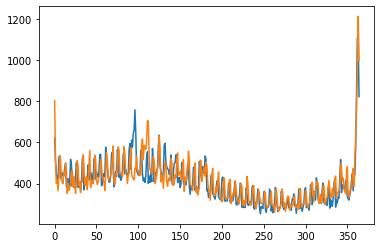

In [ ]:
plt.plot(range(len(df_all_groups[1][pd.to_datetime(df_all_groups[1].date).dt.year == 2018])),df_all_groups[1][pd.to_datetime(df_all_groups[1].date).dt.year == 2018].num_sold)
plt.plot(range(len(df_all_groups[1][pd.to_datetime(df_all_groups[1].date).dt.year == 2018])),df_all_groups[1][pd.to_datetime(df_all_groups[1].date).dt.year == 2017].num_sold*1.1)

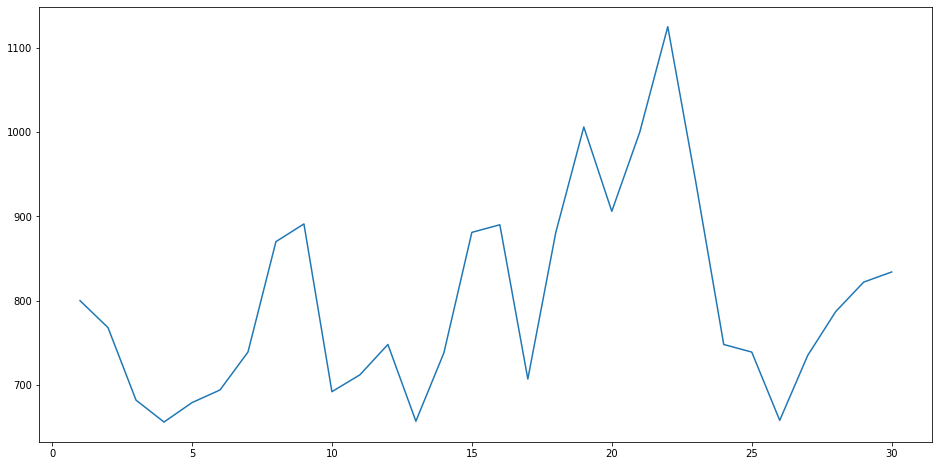

In [ ]:
idx = 10
tmp_df = df_all_groups[idx][(pd.to_datetime(df_all_groups[idx].date).dt.year == 2017) & (pd.to_datetime(df_all_groups[idx].date).dt.month.isin([4]))]
fig = plt.figure(figsize=(16,8))
plt.plot(pd.to_datetime(tmp_df.date).dt.day,tmp_df.num_sold)

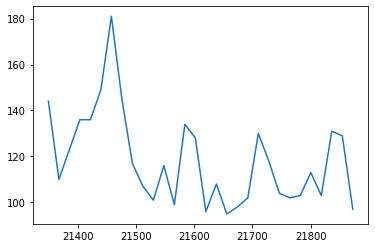

In [ ]:
df_all_groups[2][(pd.to_datetime(df_all_groups[2].date).dt.year == 2018) & (pd.to_datetime(df_all_groups[2].date).dt.month.isin([4]))].num_sold.plot()

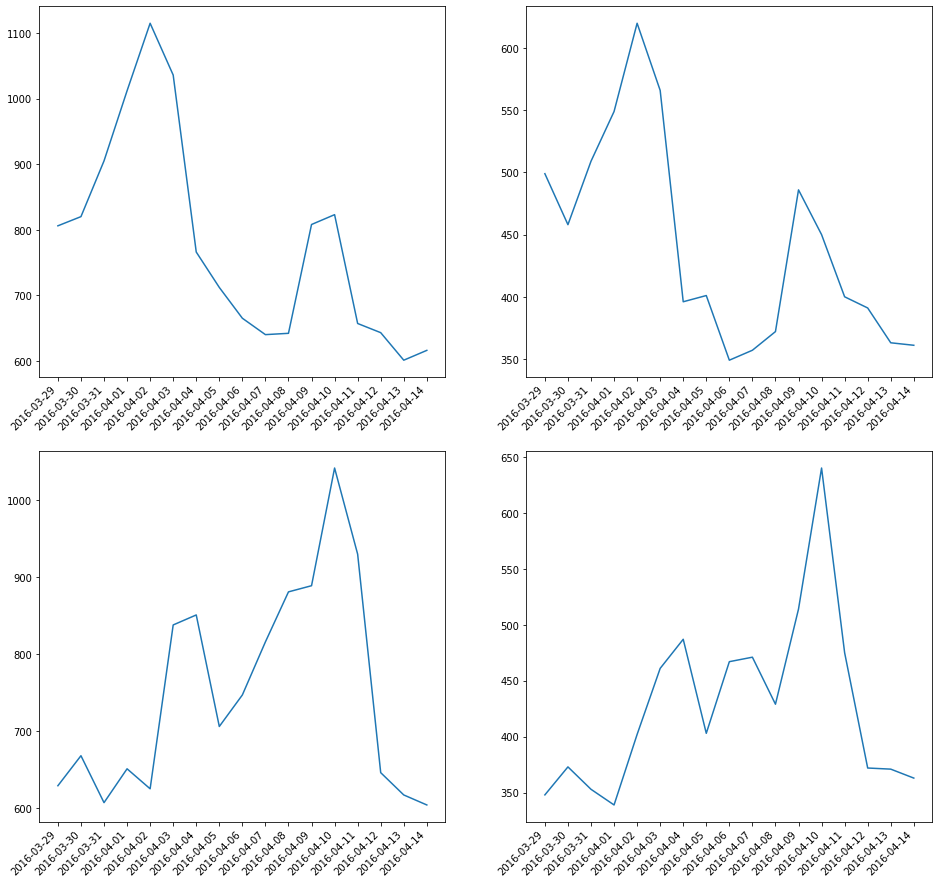

In [ ]:
#check easter time
idx = 10
fig, axs = plt.subplots(2,2,figsize=(16,15))
axs[0,0].set_xticklabels(df_all_groups[idx].date.iloc[453:470], rotation=45, ha='right')
axs[0,1].set_xticklabels(df_all_groups[idx].date.iloc[453:470], rotation=45, ha='right')
axs[1,0].set_xticklabels(df_all_groups[idx].date.iloc[453:470], rotation=45, ha='right')
axs[1,1].set_xticklabels(df_all_groups[idx].date.iloc[453:470], rotation=45, ha='right')

idx = 10
axs[0,0].plot(df_all_groups[idx].date.iloc[453:470],df_all_groups[idx].iloc[453:470].num_sold)
axs[1,0].plot(df_all_groups[idx].date.iloc[88:105],df_all_groups[idx].iloc[88:105].num_sold)

idx = 1
axs[0,1].plot(df_all_groups[idx].date.iloc[453:470],df_all_groups[idx].iloc[453:470].num_sold)
axs[1,1].plot(df_all_groups[idx].date.iloc[88:105],df_all_groups[idx].iloc[88:105].num_sold)
# plt.plot()

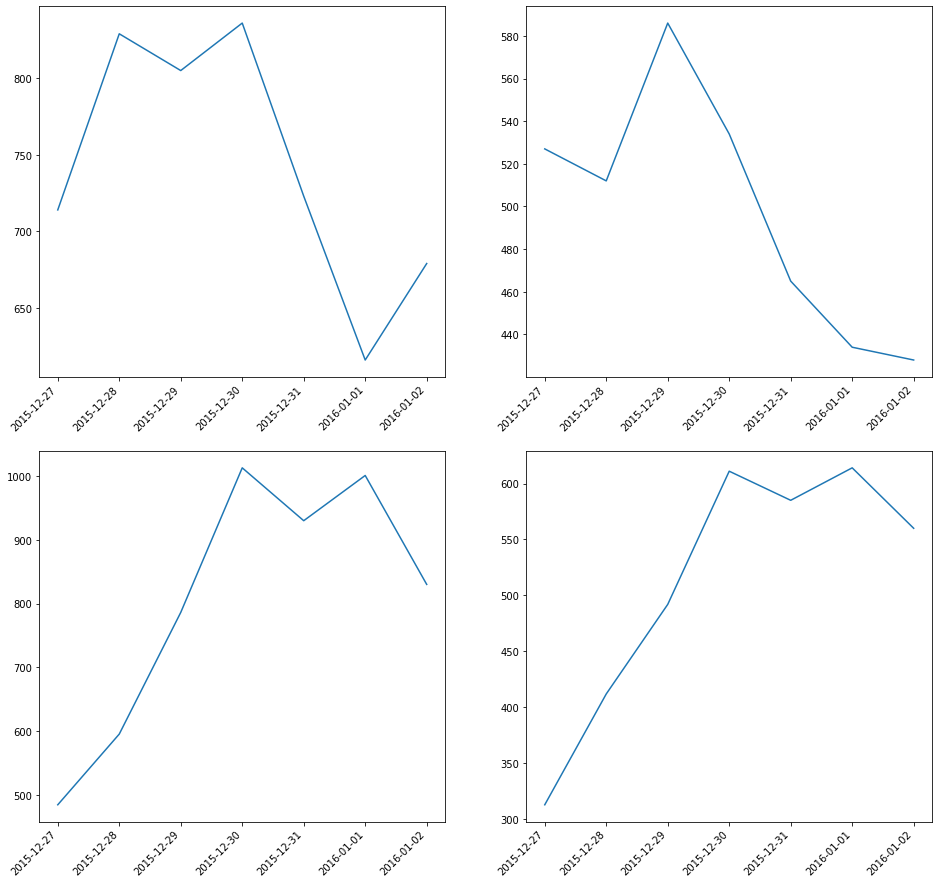

In [ ]:
#check christmas time
idx = 10
fig, axs = plt.subplots(2,2,figsize=(16,15))
axs[0,0].set_xticklabels(df_all_groups[idx].date.iloc[360:367], rotation=45, ha='right')
axs[0,1].set_xticklabels(df_all_groups[idx].date.iloc[360:367], rotation=45, ha='right')
axs[1,0].set_xticklabels(df_all_groups[idx].date.iloc[360:367], rotation=45, ha='right')
axs[1,1].set_xticklabels(df_all_groups[idx].date.iloc[360:367], rotation=45, ha='right')

idx = 7
axs[0,0].plot(df_all_groups[idx].date.iloc[360:367],df_all_groups[idx].iloc[360:367].num_sold)
axs[1,0].plot(df_all_groups[idx].date.iloc[725:732],df_all_groups[idx].iloc[725:732].num_sold)

idx = 6
axs[0,1].plot(df_all_groups[idx].date.iloc[360:367],df_all_groups[idx].iloc[360:367].num_sold)
axs[1,1].plot(df_all_groups[idx].date.iloc[725:732],df_all_groups[idx].iloc[725:732].num_sold)
# plt.plot()

Text(0.5, 1.0, 'Продажи в мае')

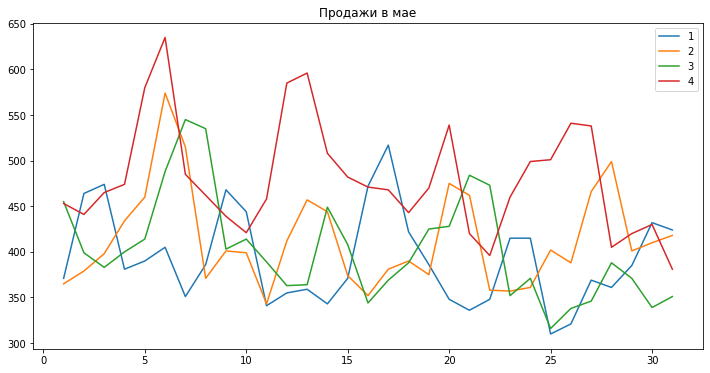

In [ ]:
fig = plt.figure(figsize=(12,6))

idx = 1

tmp_df = df_all_groups[idx][(pd.to_datetime(df_all_groups[idx].date).dt.year == 2015) & (pd.to_datetime(df_all_groups[idx].date).dt.month.isin([5]))]
plt.plot(pd.to_datetime(tmp_df.date).dt.day,tmp_df.num_sold)

tmp_df = df_all_groups[idx][(pd.to_datetime(df_all_groups[idx].date).dt.year == 2017) & (pd.to_datetime(df_all_groups[idx].date).dt.month.isin([5]))]
plt.plot(pd.to_datetime(tmp_df.date).dt.day,tmp_df.num_sold)

tmp_df = df_all_groups[idx][(pd.to_datetime(df_all_groups[idx].date).dt.year == 2016) & (pd.to_datetime(df_all_groups[idx].date).dt.month.isin([5]))]
plt.plot(pd.to_datetime(tmp_df.date).dt.day,tmp_df.num_sold)

tmp_df = df_all_groups[idx][(pd.to_datetime(df_all_groups[idx].date).dt.year == 2018) & (pd.to_datetime(df_all_groups[idx].date).dt.month.isin([5]))]
plt.plot(pd.to_datetime(tmp_df.date).dt.day,tmp_df.num_sold)

plt.legend(['1','2','3','4'])

plt.title("Продажи в мае")

In [ ]:
holidays.FIN(years=[2018]).keys()

dict_keys([datetime.date(2018, 1, 1), datetime.date(2018, 1, 6), datetime.date(2018, 3, 30), datetime.date(2018, 4, 1), datetime.date(2018, 4, 2), datetime.date(2018, 5, 1), datetime.date(2018, 5, 10), datetime.date(2018, 5, 20), datetime.date(2018, 6, 23), datetime.date(2018, 11, 3), datetime.date(2018, 12, 6), datetime.date(2018, 12, 25), datetime.date(2018, 12, 26), datetime.date(2018, 6, 22), datetime.date(2018, 12, 24)])

Text(0.5, 1.0, 'Продажи в Апреле')

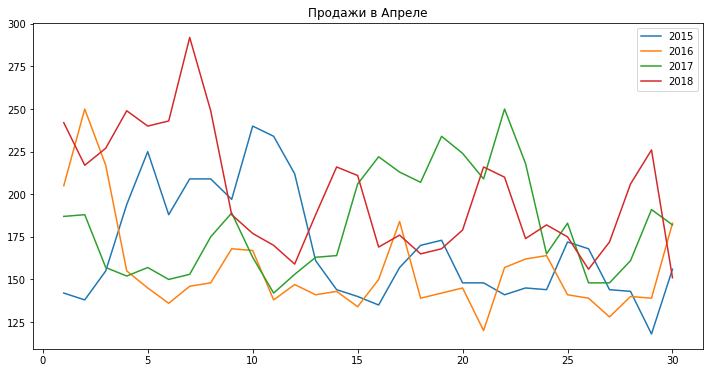

In [ ]:
idx = 5
tmp_df = df_all_groups[idx][(pd.to_datetime(df_all_groups[idx].date).dt.year == 2015) & (pd.to_datetime(df_all_groups[idx].date).dt.month.isin([4]))]
fig = plt.figure(figsize=(12,6))
plt.plot(pd.to_datetime(tmp_df.date).dt.day,tmp_df.num_sold)

tmp_df = df_all_groups[idx][(pd.to_datetime(df_all_groups[idx].date).dt.year == 2016) & (pd.to_datetime(df_all_groups[idx].date).dt.month.isin([4]))]
plt.plot(pd.to_datetime(tmp_df.date).dt.day,tmp_df.num_sold)

tmp_df = df_all_groups[idx][(pd.to_datetime(df_all_groups[idx].date).dt.year == 2017) & (pd.to_datetime(df_all_groups[idx].date).dt.month.isin([4]))]
plt.plot(pd.to_datetime(tmp_df.date).dt.day,tmp_df.num_sold)

tmp_df = df_all_groups[idx][(pd.to_datetime(df_all_groups[idx].date).dt.year == 2018) & (pd.to_datetime(df_all_groups[idx].date).dt.month.isin([4]))]
plt.plot(pd.to_datetime(tmp_df.date).dt.day,tmp_df.num_sold)

plt.legend(['2015','2016','2017','2018'])

plt.title("Продажи в Апреле")

Text(0.5, 1.0, 'Продажи в Январе')

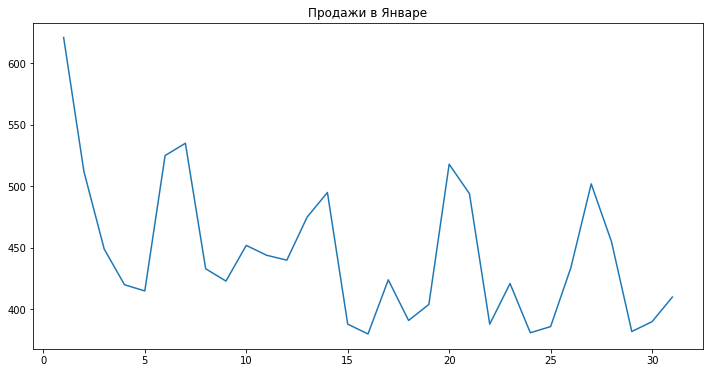

In [ ]:
idx = 1
tmp_df = df_all_groups[idx][(pd.to_datetime(df_all_groups[idx].date).dt.year == 2018) & (pd.to_datetime(df_all_groups[idx].date).dt.month.isin([1]))]
fig = plt.figure(figsize=(12,6))
plt.plot(pd.to_datetime(tmp_df.date).dt.day,tmp_df.num_sold)
plt.title("Продажи в Январе")

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
results = seasonal_decompose(df_all_groups[0].num_sold)

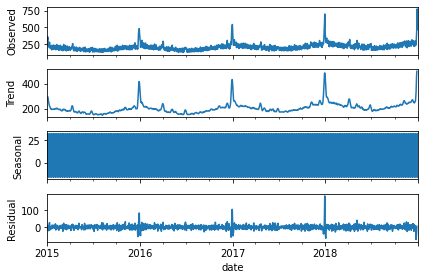

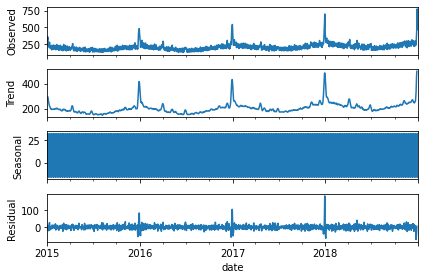

In [ ]:
results.plot()

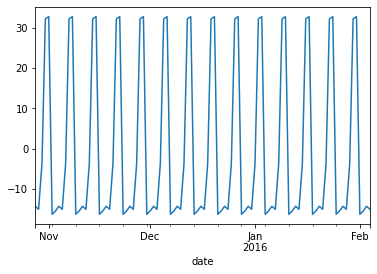

In [ ]:
results.seasonal.iloc[300:400].plot()

## Cubic spline gdp

In [ ]:
from scipy.interpolate import CubicSpline

In [ ]:
x = [2015, 2016, 2017, 2018, 2019]
y = [505.104, 515.655, 541.019, 555.455, 533.880]

In [ ]:
cs = CubicSpline(x, y)

In [ ]:
new_x = np.arange(2015,2016+1/12,1/12)

In [ ]:
new_x

array([2015.        , 2015.08333333, 2015.16666667, 2015.25      ,
       2015.33333333, 2015.41666667, 2015.5       , 2015.58333333,
       2015.66666667, 2015.75      , 2015.83333333, 2015.91666667,
       2016.        ])

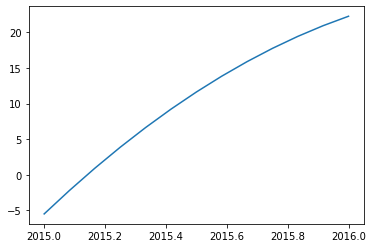

In [ ]:
plt.plot(new_x,cs(new_x,1))

In [ ]:
from scipy.interpolate import CubicSpline, LinearNDInterpolator
import matplotlib.pyplot as plt
x = [2015, 2016, 2017, 2018, 2019]
y = [505.104, 515.655, 541.019, 555.455, 533.880]
cs = LinearNDInterpolator(x, y)
xs = np.arange(2015,2020,1/12)
fig, ax = plt.subplots(figsize=(6.5, 4))
ax.plot(x, y, 'o', label='data')
# ax.plot(xs, np.sin(xs), label='true')
ax.plot(xs, cs(xs,0), label="S")
# ax.set_xlim(-0.5, 9.5)
ax.legend(loc='lower left', ncol=2)
plt.show()

In [ ]:
cs(xs)

array([505.104     , 504.78532952, 504.7344348 , 504.93632422,
       505.37600617, 506.03848905, 506.90878125, 507.97189116,
       509.21282716, 510.61659766, 512.16821103, 513.85267568,
       515.655     , 517.56019237, 519.55326119, 521.61921484,
       523.74306173, 525.90981023, 528.10446875, 530.31204567,
       532.51754938, 534.70598828, 536.86237076, 538.9717052 ,
       541.019     , 542.98935875, 544.86826582, 546.64130078,
       548.29404321, 549.81207268, 551.18096875, 552.386311  ,
       553.41367901, 554.24865234, 554.87681057, 555.28373327,
       555.455     , 555.37619035, 555.03288387, 554.41066016,
       553.49509877, 552.27177927, 550.72628125, 548.84418427,
       546.6110679 , 544.01251172, 541.03409529, 537.6613982 ,
       533.88      , 529.67548028, 525.0334186 , 519.93939453,
       514.37898765, 508.33777754, 501.80134375, 494.75526587,
       487.18512346, 479.07649609, 470.41496335, 461.18610479])

In [ ]:
cs(xs)[12:24]

array([515.655     , 517.56019237, 519.55326119, 521.61921484,
       523.74306173, 525.90981023, 528.10446875, 530.31204567,
       532.51754938, 534.70598828, 536.86237076, 538.9717052 ])

In [ ]:
xs.size

60

## Feature enginering

In [ ]:
def season(month):
    if month == [12,1,2]:
        return 1
    elif month in [3,4,5]:
        return 2
    elif month in [6,7,8]:
        return 3
    else:
        return 4

In [ ]:
def prepareData(data_, test_size=0.15):
    test_index = int(len(data_)*(1-test_size))
    # test_index = 365*3
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data_.loc[:test_index].drop(["y"], axis=1)
    y_train = data_.loc[:test_index]["y"]
    X_test = data_.loc[test_index:].drop(["y"], axis=1)
    y_test = data_.loc[test_index:]["y"]

    return X_train, X_test, y_train, y_test

In [ ]:
def feature_eng(data,date_index, country_idx,is_train=True):

    # tmp = date_index.copy()
    data.index = pd.to_datetime(date_index)

    fin_holidays = holidays.FIN(years=[2015,2016,2017,2018,2019]).keys()
    swe_holidays = holidays.SWE(years=[2015,2016,2017,2018,2019]).keys()
    nor_holidays = holidays.NOR(years=[2015,2016,2017,2018,2019]).keys()

    easter_time_list_1 = ['2015-04-01','2015-04-02','2015-04-03','2015-04-04','2015-04-05','2015-04-06','2015-04-07','2015-04-08',
                          '2016-04-01','2016-04-02','2016-04-03','2016-04-04','2016-04-05','2016-04-06','2016-04-07','2016-04-08',
                          '2017-04-01','2017-04-02','2017-04-03','2017-04-04','2017-04-05','2017-04-06','2017-04-07','2017-04-08',
                          '2018-04-01','2018-04-02','2018-04-03','2018-04-04','2018-04-05','2018-04-06','2018-04-07','2018-04-08',
                          '2019-04-01','2019-04-02','2019-04-03','2019-04-04','2019-04-05','2019-04-06','2019-04-07','2019-04-08']

    easter_time_list_2 = ['2015-04-16','2015-04-17','2015-04-18','2015-04-19','2015-04-20','2015-04-21','2015-04-22','2015-04-23',
                          '2016-04-16','2016-04-17','2016-04-18','2016-04-19','2016-04-20','2016-04-21','2016-04-22','2016-04-23',
                          '2017-04-16','2017-04-17','2017-04-18','2017-04-19','2017-04-20','2017-04-21','2017-04-22','2017-04-23',
                          '2018-04-16','2018-04-17','2018-04-18','2018-04-19','2018-04-20','2018-04-21','2018-04-22','2018-04-23',
                          '2019-04-16','2019-04-17','2019-04-18','2019-04-19','2019-04-20','2019-04-21','2019-04-22','2019-04-23']

    christmas_time_list = ['2015-12-27','2015-12-28','2015-12-29','2015-12-30','2015-12-31','2016-01-01','2016-01-02','2016-01-03',
                           '2016-12-27','2016-12-28','2016-12-29','2016-12-30','2016-12-31','2017-01-01','2017-01-02','2017-01-03',
                           '2017-12-27','2017-12-28','2017-12-29','2017-12-30','2017-12-31','2018-01-01','2018-01-02','2018-01-03',
                           '2018-12-27','2018-12-28','2018-12-29','2018-12-30','2018-12-31','2019-01-01','2019-01-02','2019-01-03',
                           '2019-12-27','2019-12-28','2019-12-29','2019-12-30','2019-12-31']  


    may_max_list = ['2015-05-06','2015-05-07',
                    '2016-05-06','2016-05-07',
                    '2017-05-06','2017-05-07',
                    '2018-05-06','2018-05-07',
                    '2019-05-06','2019-05-07']

    fin_holidays_list = []
    swe_holidays_list = []
    nor_holidays_list = []

    for date in fin_holidays:
        fin_holidays_list.append(str(date))    
    for date in swe_holidays:
        swe_holidays_list.append(str(date))            
    for date in nor_holidays:
        nor_holidays_list.append(str(date))    

    data = pd.DataFrame(data.copy())
    data.columns = ["y"]

    fin_idx = [0,1,2,9,10,11]
    nor_idx = [3,4,5,12,13,14]
    swe_idx = [6,7,8,15,16,17]

    data['is_weekend'] = data.index.weekday.isin([5,6])*1
    data['gdp_prev'] = 0
    data['gdp'] = 0
    data['cpi'] = 0
    if country_idx in fin_idx:
        data['is_holiday_fin'] = data.index.isin(fin_holidays_list)*1
        data['is_holiday_fin_weekend'] = data['is_holiday_fin']*data['is_weekend']      
        data['gdp'][data.index.year == 2015] = 234.440
        data['gdp'][data.index.year == 2016] = 240.608
        data['gdp'][data.index.year == 2017] = 255.017
        data['gdp'][data.index.year == 2018] = 275.580
        data['gdp'][data.index.year == 2019] = 268.782

        data['gdp_prev'][data.index.year == 2015] = 274.487
        data['gdp_prev'][data.index.year == 2016] = 234.440
        data['gdp_prev'][data.index.year == 2017] = 240.608
        data['gdp_prev'][data.index.year == 2018] = 255.017
        data['gdp_prev'][data.index.year == 2019] = 275.580          

        data['cpi'][data.index.year == 2015] = -0.2
        data['cpi'][data.index.year == 2016] = 0.4
        data['cpi'][data.index.year == 2017] = 0.8
        data['cpi'][data.index.year == 2018] = 1.2
        data['cpi'][data.index.year == 2019] = 1.1        
    if country_idx in nor_idx:
        data['is_holiday_nor'] = data.index.isin(nor_holidays_list)*1
        data['is_holiday_nor_weekend'] = data['is_holiday_nor']*data['is_weekend']       
        data['gdp'][data.index.year == 2015] = 385.802
        data['gdp'][data.index.year == 2016] = 368.827
        data['gdp'][data.index.year == 2017] = 398.394
        data['gdp'][data.index.year == 2018] = 437.000
        data['gdp'][data.index.year == 2019] = 405.510 

        data['gdp_prev'][data.index.year == 2015] = 498.410
        data['gdp_prev'][data.index.year == 2016] = 385.802
        data['gdp_prev'][data.index.year == 2017] = 368.827
        data['gdp_prev'][data.index.year == 2018] = 398.394
        data['gdp_prev'][data.index.year == 2019] = 437.000         

        data['cpi'][data.index.year == 2015] = 2.2
        data['cpi'][data.index.year == 2016] = 3.6
        data['cpi'][data.index.year == 2017] = 1.9
        data['cpi'][data.index.year == 2018] = 2.8
        data['cpi'][data.index.year == 2019] = 2.2
    if country_idx in swe_idx:
        data['is_holiday_swe'] = data.index.isin(swe_holidays_list)*1
        data['is_holiday_swe_weekend'] = data['is_holiday_swe']*data['is_weekend']      
        data['gdp'][data.index.year == 2015] = 505.104
        data['gdp'][data.index.year == 2016] = 515.655
        data['gdp'][data.index.year == 2017] = 541.019
        data['gdp'][data.index.year == 2018] = 555.455
        data['gdp'][data.index.year == 2019] = 533.880  

        data['gdp_prev'][data.index.year == 2015] = 581.964
        data['gdp_prev'][data.index.year == 2016] = 505.104
        data['gdp_prev'][data.index.year == 2017] = 515.655
        data['gdp_prev'][data.index.year == 2018] = 541.019
        data['gdp_prev'][data.index.year == 2019] = 555.455   
        
        data['cpi'][data.index.year == 2015] = 0.7
        data['cpi'][data.index.year == 2016] = 1.1
        data['cpi'][data.index.year == 2017] = 1.9
        data['cpi'][data.index.year == 2018] = 2.0
        data['cpi'][data.index.year == 2019] = 1.6            

    data['gdp_prev'] = np.log(data['gdp_prev'])
    # data['cpi'] = (data['cpi'])
    data['gdp'] = np.log(data['gdp'])
    data.y = np.log(data.y)    

    data["month"] = data.index.month
    data["weekday"] = data.index.weekday
    data["dayOfYear"] = data.index.dayofyear  

    # data["day"] = data.index.day

    data["is_1_month"] = data.index.day.isin([1,2,3,4,5,6,7,8,9,10])*1
    data["is_2_month"] = data.index.day.isin([11,12,13,14,15,16,17,18,19,20])*1
    data["3_month"] = data.index.day.isin([21,22,23,24,25,26,27,28,29,30,31])*1

    # data['day_full'] = (pd.to_datetime(data.index.) - pd.to_datetime(datetime.date(2015,1,1))).dt.components.days

    data["week"] = data.index.week
    # df_all_groups
    
    data["year"] = data.index.year
    data['is_friday'] = data.index.weekday.isin([4])*1

    data['fst_half_week'] = data.index.weekday.isin([7,1,2,3])*1
    data['scd_half_week'] = data.index.weekday.isin([4,5,6])*1

    data['is_easter_1'] = data.index.isin(easter_time_list_1)*(data.index.year+1)%2
    data['is_easter_2'] = data.index.isin(easter_time_list_2)*data.index.year%2
    data['year_mod2'] = data.index.year%2

    data['may_holiday'] = data.index.isin(may_max_list)*1
    data['is_christmas'] = data.index.isin(christmas_time_list)*1

    # data.drop(data[(data.index.month == 2) & (data.index.day == 29)].index,axis=0,inplace=True)
    # data['mean_month'] = 0
    # data['max_month'] = 0
    # data['min_month'] = 0
    # # data['str_month'] = 0
    # for m in data.index.month.unique():
    #     for y in data.index.year.unique():
    #         try:
    #             # data['mean_month'][(data.year == y) & (data.month == m)] = float(data[(data.year == y) & (data.month == m)].groupby(by=['year','month']).var().y) 
    #             data['max_month'][(data.year == y) & (data.month == m)] = float(data[(data.year == y) & (data.month == m)].groupby(by=['year','month']).max().y) 
    #             data['min_month'][(data.year == y) & (data.month == m)] = float(data[(data.year == y) & (data.month == m)].groupby(by=['year','month']).min().y)
    #             # data['std_month'][(data.year == y) & (data.month == m)] = float(data[(data.year == y) & (data.month == m)].groupby(by=['year','month']).std().y)  
    #         except:
    #             continue

    data["season"] = data.month.apply(lambda x : season(x))
    data.drop(columns=['cpi','gdp_prev','year'],axis=1,inplace=True)
    # data.drop(columns=['cpi'],axis=1,inplace=True)
    # data.drop(columns=['gdp'],axis=1,inplace=True)
    data = data.reset_index(drop=True)
    return data

In [ ]:
data = []
for df,idx in zip(df_all_groups,range(18)):
    data.append(feature_eng(df.num_sold,df.date,idx))

In [ ]:
data_test = []
for df,idx in zip(df_all_groups_test,range(18)):
    # df['num_sold'] = 0
    data_test.append(feature_eng(df.num_sold,df.date,idx))

## Prophet

In [ ]:
!pip install prophet

In [ ]:
from prophet import Prophet

In [ ]:
m = Prophet()

In [ ]:
df_tmp = pd.DataFrame({'ds':df_all_groups[1].date,
                       'y':df_all_groups[1].num_sold})

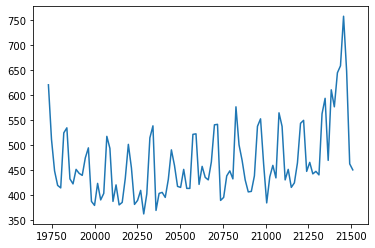

In [ ]:
df_tmp[-365:][:100].y.plot()

In [ ]:
df_tmp.head()

,DS,Y
1,2015-01-01,520
19,2015-01-02,493
37,2015-01-03,535
55,2015-01-04,544
73,2015-01-05,378


In [ ]:
m.fit(df_tmp)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
1821,2019-12-27
1822,2019-12-28
1823,2019-12-29
1824,2019-12-30
1825,2019-12-31


In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1821,2019-12-27,565.667152,501.383615,627.957748
1822,2019-12-28,642.270610,582.591796,706.219850
1823,2019-12-29,644.006837,583.958153,711.782059
1824,2019-12-30,563.655703,500.884043,626.207631
1825,2019-12-31,568.268450,505.538596,634.532913


In [ ]:
forplot = forecast[-365:][:100]

In [ ]:
forplot.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1461,2019-01-01,417.466886,486.339531,614.076654,417.466886,417.466886,130.684216,130.684216,130.684216,-27.802223,-27.802223,-27.802223,158.486439,158.486439,158.486439,0.0,0.0,0.0,548.151102
1462,2019-01-02,417.527089,489.469657,612.773902,417.527089,417.527089,132.638144,132.638144,132.638144,-25.500606,-25.500606,-25.500606,158.138750,158.138750,158.138750,0.0,0.0,0.0,550.165233
1463,2019-01-03,417.587293,489.079494,612.213127,417.587293,417.587293,129.988042,129.988042,129.988042,-26.254239,-26.254239,-26.254239,156.242282,156.242282,156.242282,0.0,0.0,0.0,547.575335
1464,2019-01-04,417.647496,497.537217,627.513514,417.647496,417.647496,144.758414,144.758414,144.758414,-8.102437,-8.102437,-8.102437,152.860851,152.860851,152.860851,0.0,0.0,0.0,562.405910
1465,2019-01-05,417.707699,562.648975,691.587318,417.707699,417.707699,208.790979,208.790979,208.790979,60.707052,60.707052,60.707052,148.083927,148.083927,148.083927,0.0,0.0,0.0,626.498677


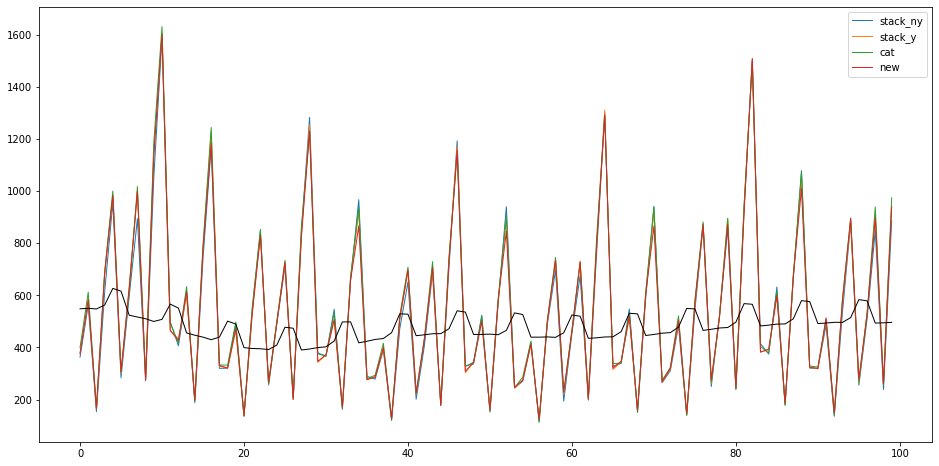

In [ ]:
fig = plt.figure(figsize=(16,8))
plt.plot(range(0,df_stack_14plt.num_sold.size),df_stack_14plt.num_sold,linewidth=1)
plt.plot(range(0,df_stack_24plt.num_sold.size),df_stack_24plt.num_sold,linewidth=1)
plt.plot(range(0,df_stack_34plt.num_sold.size),df_stack_34plt.num_sold,linewidth=1)
plt.plot(range(0,df_stack_44plt.num_sold.size),df_stack_44plt.num_sold,linewidth=1)
plt.plot(range(0,100),forplot.yhat,linewidth=1,c='black')
# fig = plt.figure(figsize=(16,8))
plt.legend(['stack_ny','stack_y','cat','new'])
# plt.legend(['new_stack','final_old','final_new'])

## Keras sequental

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
model = Sequential()
# model.add(layers.Dense(64, input_dim=30,
#                 activity_regularizer=keras.regularizers.l2(0.01)))
# model.add(layers.BatchNormalization())
# model.add(layers.LeakyReLU())
# model.add(layers.Dense(16,
#                 activity_regularizer=keras.regularizers.l2(0.01)))
# model.add(layers.BatchNormalization())
# model.add(layers.LeakyReLU())
# model.add(layers.Dense(1))
# model.add(layers.Activation('linear'))

In [ ]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.000001, verbose=1)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
X_train, X_test, y_train, y_test = prepareData(data[1],0.2)

In [ ]:
# history = model.fit(X_train, y_train, 
#           epochs = 50, 
#           batch_size = 128, 
#           verbose = 1, 
#           # validation_data = (X_test, y_test),
#           shuffle = True,
#           callbacks = [reduce_lr])

In [ ]:
pred = model.predict(np.array(X_test))
original = Y_test
predicted = pred

plt.plot(original, color='black', label = 'Original data')
plt.plot(predicted, color='blue', label = 'Predicted data')
plt.legend(loc='best')
plt.title('Actual and predicted')
plt.show()

## Linear regression

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
lr_all = []
for d in data:
    lr = LinearRegression()
    lr_all.append(lr.fit(d.drop(columns=['y'],axis=1), d.y))

Predict

In [ ]:
len(df_all_groups_test)

18

In [ ]:
predictions = []
for model,d_test in zip(lr_all,data_test):
    predictions.append(model.predict(d_test.drop(columns=['y'],axis=1)))

In [ ]:
for pred, d_test in zip(predictions,df_all_groups_test):
    d_test['num_sold'] = pred

In [ ]:
df_test_result = pd.concat([x for x in df_all_groups_test])

In [ ]:
submition = df_test_result.sort_values(by='row_id')[['row_id','num_sold']].set_index('row_id')

In [ ]:
submition.to_csv("submition_lr.csv")

## XGBRegressor tuning

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
X_train, X_test, y_train, y_test = prepareData(data[1],0.2)

In [ ]:
xgb = XGBRegressor(silent=True,)
grid = {'learning_rate': [0.99,0.1,1.01],
        'max_depth': [3],
        # 'subsample': [1,3,5],
        'reg_alpha':[0,1,2],
        'reg_lambda':[0,1,2],
        'n_estimators':[90,100,110]}

In [ ]:
xbg_grid_s = GridSearchCV(xgb,grid)

In [ ]:
xbg_grid_s.fit(X_train,y_train)

GridSearchCV(estimator=XGBRegressor(silent=True),
             param_grid={'learning_rate': [0.99, 0.1, 1.01], 'max_depth': [3],
                         'n_estimators': [90, 100, 110], 'reg_alpha': [0, 1, 2],
                         'reg_lambda': [0, 1, 2]})

In [ ]:
xbg_grid_s.best_estimator_

XGBRegressor(learning_rate=0.5, max_depth=5, n_estimators=20, silent=True)

In [ ]:
tr_pred = xbg_grid_s.best_estimator_.predict(X_train)
ts_pred = xbg_grid_s.best_estimator_.predict(X_test)
print(mean_squared_log_error(np.exp(y_train),np.exp(tr_pred)))
print(mean_squared_log_error(np.exp(y_test),np.exp(ts_pred)))

0.002095127368829648
0.01393076133792846


In [ ]:
xgb_default = XGBRegressor().fit(X_train,y_train)

[23:28:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
xgb_default.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'importance_type': 'gain',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'reg:linear',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

In [ ]:
tr_pred = xgb_default.predict(X_train)
ts_pred = xgb_default.predict(X_test)
print(mean_squared_log_error(np.exp(y_train),np.exp(tr_pred)))
print(mean_squared_log_error(np.exp(y_test),np.exp(ts_pred)))

0.0033812675191921943
0.013683530392349236


## CATboost

In [ ]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_log_error 

In [ ]:
X_train, X_test, y_train, y_test = prepareData(data[1],0.25)

In [ ]:
catTesting = CatBoostRegressor(
    random_state =79378,
    # n_estimators=3000,
    loss_function = 'MAE',
    # eval_metric = 'SMAPE',    
    verbose=False
    )

In [ ]:
model = catTesting
grid = {'learning_rate': [0.5,0.55],
        'depth': [3],
        'l2_leaf_reg': [5],
        'n_estimators':[90,100,120]}

In [ ]:
grid_search_result = model.grid_search(grid, 
                                       X=X_train, 
                                       y=y_train, 
                                       verbose=False
                                      )


bestTest = 0.0577448559
bestIteration = 89


bestTest = 0.05711179452
bestIteration = 83


bestTest = 0.05682498438
bestIteration = 99


bestTest = 0.05709663669
bestIteration = 99


bestTest = 0.05563091262
bestIteration = 117


bestTest = 0.05652510519
bestIteration = 117

Training on fold [0/3]

bestTest = 0.05387142131
bestIteration = 72

Training on fold [1/3]

bestTest = 0.05584934374
bestIteration = 118

Training on fold [2/3]

bestTest = 0.071625077
bestIteration = 79



In [ ]:
model.get_params()

{'depth': 3,
 'iterations': 90,
 'l2_leaf_reg': 5,
 'learning_rate': 0.5,
 'loss_function': 'MAE',
 'random_state': 79378,
 'verbose': False}

In [ ]:
pd.DataFrame({
    'imp':model.get_feature_importance(),
    'col':X_train.columns
    }).sort_values(by='imp',ascending=False)

,imp,col
10,41.276045,week
17,17.746680,is_christmas
5,13.967101,weekday
6,11.012498,dayOfYear
1,4.995265,gdp_diff
4,4.047054,month
0,2.244125,is_weekend
2,1.376052,gdp
3,0.895844,cpi
14,0.753700,is_easter_2


In [ ]:
!pip install shap --quiet

     |████████████████████████████████| 564 kB 5.2 MB/s 


In [ ]:
import shap

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

In [ ]:
feat = X_train.columns

In [ ]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X_train.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=True,inplace=True)
feature_importance.head(5)

,col_name,feature_importance_vals
14,is_easter_1,0.000174
3,is_holiday_fin_weekend,0.000439
17,may_holiday,0.000748
12,fst_half_week,0.001514
8,is_2_month,0.001756


In [ ]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X_train.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance.head(25)

,col_name,feature_importance_vals
19,max_month,0.077441
0,is_weekend,0.062314
20,min_month,0.059506
6,dayOfYear,0.039702
1,gdp,0.033644
5,weekday,0.022888
10,week,0.017198
18,is_christmas,0.012776
7,is_1_month,0.006266
21,season,0.005795


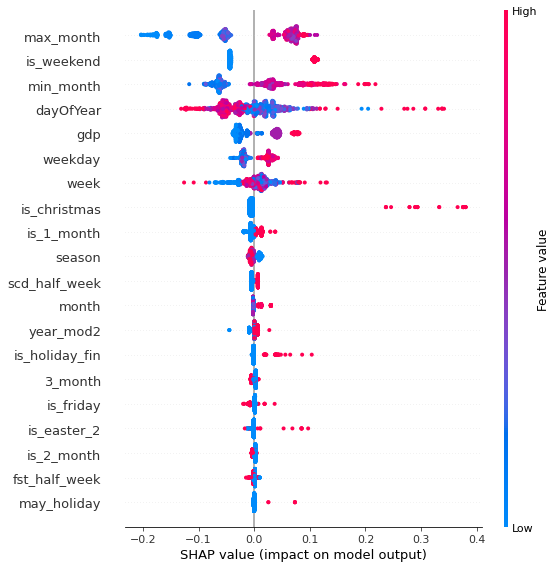

In [ ]:
shap.summary_plot(shap_values, X_train)

In [ ]:
model.get_params()

{'depth': 3,
 'iterations': 120,
 'l2_leaf_reg': 5,
 'learning_rate': 0.55,
 'loss_function': 'MAE',
 'random_state': 79378,
 'verbose': False}

In [ ]:
tr_pred = model.predict(X_train)
ts_pred = model.predict(X_test)

In [ ]:
# pred_testing_tmp = np.floor(pred_testing)
# pred_testing_tmp = pred_testing
pred_testing_test_tmp = np.round(pred_testing_test)

In [ ]:
print(mean_squared_log_error(y_train,tr_pred))
print(mean_squared_log_error(y_test,ts_pred))

0.00010029284568264523
0.00017072358352126206


In [ ]:
print(mean_squared_log_error(np.exp(y_train),np.exp(tr_pred)))
print(mean_squared_log_error(np.exp(y_test),np.exp(ts_pred)))

0.002912242528754637
0.005664834375167657


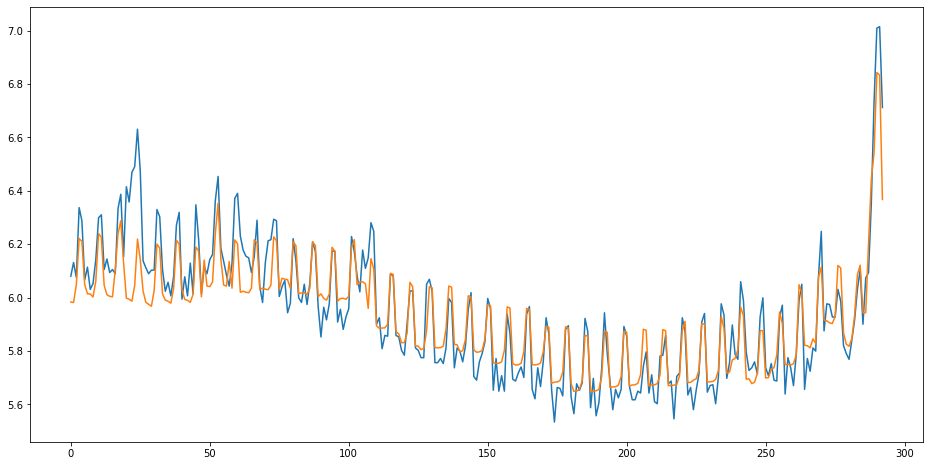

In [ ]:
fig = plt.figure(figsize=(16,8))
plt.plot(range(0,y_test.size),y_test)
plt.plot(range(0,ts_pred.size),ts_pred)

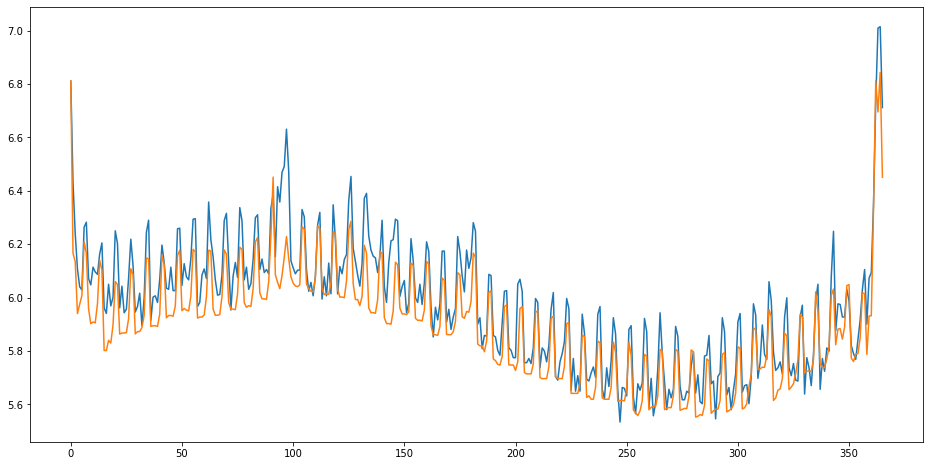

In [ ]:
fig = plt.figure(figsize=(16,8))
plt.plot(range(0,y_test.size),y_test)
plt.plot(range(0,ts_pred.size),ts_pred)

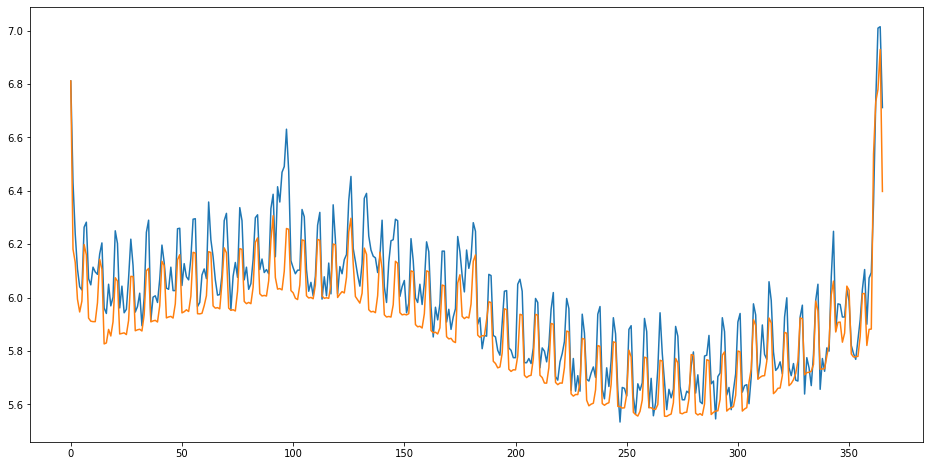

In [ ]:
fig = plt.figure(figsize=(16,8))
plt.plot(range(0,y_test.size),y_test)
plt.plot(range(0,ts_pred.size),ts_pred)

In [ ]:
print(mean_squared_log_error(y_test,pred_testing_test_tmp))

0.02581204785467321


In [ ]:
print(mean_squared_log_error(y_train,pred_testing))
print(mean_squared_log_error(y_test,pred_testing_test))

0.007439298105606364
0.02634340293229191


In [ ]:
scaller = StandardScaler()

In [ ]:
for i in range(18):
    features4scale = data[i].columns[1:]
    data[i][features4scale] = scaller.fit_transform(data[i][features4scale])
    data_test[i][features4scale] = scaller.transform(data_test[i][features4scale])

In [ ]:
cat_all = []
for d in data:
    model = CatBoostRegressor(
    random_state =79378,
    # n_estimators=3000, 
    loss_function = 'MAE',
    # eval_metric = 'SMAPE',    
    verbose=False
    )
    model.grid_search(grid, 
                        X=d.drop(columns=['y'],axis=1), 
                        y=d['y'], 
                        verbose=False
                      )
    cat_all.append(model)

In [ ]:
print(mean_squared_log_error(y_train,pred_testing))
print(mean_squared_log_error(y_test,pred_testing_test))

0.003637563201884303
0.016221976712342878


In [ ]:
print(mean_squared_log_error(y_train,pred_testing))
print(mean_squared_log_error(y_test,pred_testing_test))

0.008816345173370292
0.02298795595825453


In [ ]:
predictions = []
for model,d_test in zip(cat_all,data_test):
    predictions.append(model.predict(d_test.drop(columns=['y'],axis=1)))

In [ ]:
for pred, d_test in zip(predictions,df_all_groups_test):
    d_test['num_sold'] = pred

df_test_result = pd.concat([x for x in df_all_groups_test])    

In [ ]:
submition = df_test_result.sort_values(by='row_id')[['row_id','num_sold']].set_index('row_id')
submition.num_sold = np.exp(submition.num_sold)
submition.to_csv("submition_cat.csv")

In [ ]:
submition

,num_sold
row_id,
26298,202.173652
26299,299.940100
26300,205.845715
26301,312.403344
26302,756.396678
...,...
32863,559.888939
32864,153.155744
32865,434.486555


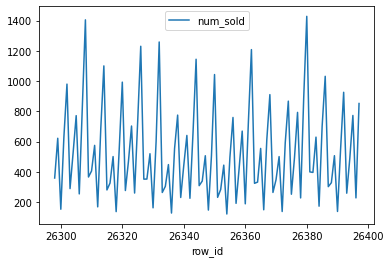

In [ ]:
submition.iloc[:100].plot()

In [ ]:
submition

,num_sold
row_id,
26298,369.854651
26299,599.091950
26300,146.802103
26301,618.748992
26302,944.507878
...,...
32863,823.073319
32864,241.182070
32865,1017.969309


## SVR

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

In [ ]:
svr = SVR()

In [ ]:
model = GridSearchCV(svr,param_grid)

In [ ]:
model.fit(X_train,y_train)

GridSearchCV(estimator=SVR(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']})

In [ ]:
# SVR(C=1000, gamma=0.01)
model.best_estimator_

SVR(C=10, gamma=0.1)

In [ ]:
tr_pred = model.predict(X_train)
ts_pred = model.predict(X_test)

In [ ]:
print(mean_squared_log_error(y_train,tr_pred))
print(mean_squared_log_error(y_test,ts_pred))

0.034682392195828894
0.0689947176566615


In [ ]:
print(mean_squared_log_error(np.exp(y_train),np.exp(tr_pred)))
print(mean_squared_log_error(np.exp(y_test),np.exp(ts_pred)))

0.0047922378145162795
0.007969287281074558


In [ ]:
print(mean_squared_log_error(np.exp(y_train),np.exp(tr_pred)))
print(mean_squared_log_error(np.exp(y_test),np.exp(ts_pred)))

0.0055693650282599904
0.0189785062580972


In [ ]:
print(mean_squared_log_error(y_train,tr_pred))
print(mean_squared_log_error(y_test,ts_pred))

0.009024159924994548
0.03151445336572965


## Ridge regression

In [ ]:
from sklearn.linear_model import Ridge

In [ ]:
ridge = Ridge()

In [ ]:
ridge.fit(X_train,y_train)

Ridge()

In [ ]:
tr_pred = ridge.predict(X_train)
ts_pred = ridge.predict(X_test)

In [ ]:
print(mean_squared_log_error(y_train,tr_pred))
print(mean_squared_log_error(y_test,ts_pred))

0.03198097897705396
0.04898915153234649


In [ ]:
print(mean_squared_log_error(np.exp(y_train),np.exp(tr_pred)))
print(mean_squared_log_error(np.exp(y_test),np.exp(ts_pred)))

0.010992523951232364
0.010163686906260364


## KNN tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
knn = KNeighborsRegressor()
grid = {'n_neighbors': [3,4,5],
        'leaf_size': [5,10,20,30],
        'p': [2.9,2.8,2.7,2.6,3,3.1]}

In [ ]:
grid_s = GridSearchCV(knn,grid)

In [ ]:
grid_s.fit(X_train,y_train)

GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'leaf_size': [5, 10, 20, 30], 'n_neighbors': [3, 4, 5],
                         'p': [2.9, 2.8, 2.7, 2.6, 3, 3.1]})

In [ ]:
grid_s.best_estimator_

KNeighborsRegressor(leaf_size=5, p=3)

In [ ]:
grid_s.best_estimator_

KNeighborsRegressor(n_neighbors=3, p=2.9)

In [ ]:
knn_tr = grid_s.best_estimator_.predict(X_train)
knn_ts = grid_s.best_estimator_.predict(X_test)

In [ ]:
print(mean_squared_log_error(y_train,knn_tr))
print(mean_squared_log_error(y_test,knn_ts))

0.00020860969026884898
0.0010215761749058578


In [ ]:
print(mean_squared_log_error(np.exp(y_train),np.exp(knn_tr)))
print(mean_squared_log_error(np.exp(y_test),np.exp(knn_ts)))

0.00880644693386807
0.0413755489366104


In [ ]:
knn = KNeighborsRegressor()

In [ ]:
knn.fit(X_train,y_train)

KNeighborsRegressor()

In [ ]:
knn_tr = knn.predict(X_train)
knn_ts = knn.predict(X_test)
print(mean_squared_log_error(np.exp(y_train),np.exp(knn_tr)))
print(mean_squared_log_error(np.exp(y_test),np.exp(knn_ts)))

0.00019596172578667878
0.000799646772362617


In [ ]:
knn_tr = knn.predict(X_train)
knn_ts = knn.predict(X_test)
print(mean_squared_log_error(np.exp(y_train),np.exp(knn_tr)))
print(mean_squared_log_error(np.exp(y_test),np.exp(knn_ts)))

0.00857927543484164
0.040802611040384164


## ElasticNet

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

In [ ]:
X_train, X_test, y_train, y_test = prepareData(data[1],0.2)

In [ ]:
elnet = ElasticNet()

In [ ]:
grid = {
    'alpha':[0,1,2],
    'l1_ratio':[0,0.3,0.5,0.8,1]
    }

In [ ]:
grid_elastic_s = GridSearchCV(elnet,grid).fit(X_train,y_train)

In [ ]:
grid_elastic_s.best_estimator_

ElasticNet(alpha=0, l1_ratio=0)

In [ ]:
tr_pred = grid_elastic_s.best_estimator_.predict(X_train)
ts_pred = grid_elastic_s.best_estimator_.predict(X_test)
print(mean_squared_log_error(y_train,tr_pred))
print(mean_squared_log_error(y_test,ts_pred))

0.0003108362334628294
0.00030017843641963585


In [ ]:
tr_pred = grid_elastic_s.best_estimator_.predict(X_train)
ts_pred = grid_elastic_s.best_estimator_.predict(X_test)
print(mean_squared_log_error(np.expm1(y_train),np.expm1(tr_pred)))
print(mean_squared_log_error(np.expm1(y_test),np.expm1(ts_pred)))

0.014753847104153983
0.014584799635859971


In [ ]:
tr_pred = grid_elastic_s.best_estimator_.predict(X_train)
ts_pred = grid_elastic_s.best_estimator_.predict(X_test)
print(mean_squared_log_error(np.exp(y_train),np.exp(tr_pred)))
print(mean_squared_log_error(np.exp(y_test),np.exp(ts_pred)))

0.010844928632340968
0.009793990255339752


In [ ]:
elnet.fit(X_train,y_train)

ElasticNet()

In [ ]:
tr_pred = elnet.predict(X_train)
ts_pred = elnet.predict(X_test)
print(mean_squared_log_error(y_train,tr_pred))
print(mean_squared_log_error(y_test,ts_pred))

0.030207406719920456
0.03894305505333044


In [ ]:
tr_pred = elnet.predict(X_train)
ts_pred = elnet.predict(X_test)
print(mean_squared_log_error(np.expm1(y_train),np.expm1(tr_pred)))
print(mean_squared_log_error(np.expm1(y_test),np.expm1(ts_pred)))

0.041782443846717976
0.07118401666639802


## MLPRegressor tuning

In [ ]:
MLP_default = MLPRegressor().fit(X_train,y_train)

In [ ]:
tr_pred = MLP_default.predict(X_train)
ts_pred = MLP_default.predict(X_test)
print(mean_squared_log_error(y_train,tr_pred))
print(mean_squared_log_error(y_test,ts_pred))

0.019925446472549176
0.039837658509243576


In [ ]:
tr_pred = MLP_default.predict(X_train)
ts_pred = MLP_default.predict(X_test)
print(mean_squared_log_error(np.exp(y_train),np.exp(tr_pred)))
print(mean_squared_log_error(np.exp(y_test),np.exp(ts_pred)))

0.011714469927120831
0.016308967996836437


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaller = MinMaxScaler()

In [ ]:
X_train_scaller = scaller.fit_transform(X_train)
X_test_scaller = scaller.transform(X_test)

In [ ]:
MLP = MLPRegressor(
    hidden_layer_sizes=(72,24),
    alpha=1e-05,
    activation='relu',
    learning_rate='adaptive',
    batch_size = 365,
    early_stopping=True,
    tol=0.0001,
    max_iter=20000,
    random_state=123)

grid = {
    'alpha':[1e-03],
}
MLP_search = GridSearchCV(MLP,grid)
MLP_search.fit(X_train_scaller,y_train)

GridSearchCV(estimator=MLPRegressor(alpha=1e-05, batch_size=365,
                                    early_stopping=True,
                                    hidden_layer_sizes=(72, 24),
                                    learning_rate='adaptive', max_iter=20000,
                                    random_state=123),
             param_grid={'alpha': [0.001]})

In [ ]:
MLP_search.best_estimator_

MLPRegressor(alpha=0.001, batch_size=365, early_stopping=True,
             hidden_layer_sizes=(72, 24), learning_rate='adaptive',
             max_iter=20000, random_state=123)

In [ ]:
tr_pred = MLP_search.predict(X_train_scaller)
ts_pred = MLP_search.predict(X_test_scaller)
print(mean_squared_log_error(y_train,tr_pred))
print(mean_squared_log_error(y_test,ts_pred))

0.014875186715441231
0.01737123972751019


In [ ]:
tr_pred = MLP_search.predict(X_train_scaller)
ts_pred = MLP_search.predict(X_test_scaller)
print(mean_squared_log_error(np.exp(y_train),np.exp(tr_pred)))
print(mean_squared_log_error(np.exp(y_test),np.exp(ts_pred)))

0.006682822152304995
0.019081676578946365


## Stacking

In [ ]:
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import Ridge, LinearRegression, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

In [ ]:
estimators = [
    ('CAT',CatBoostRegressor(
                          loss_function='MAE',
                          random_seed = 123,
                          verbose=50)),
    # ('KNN',KNeighborsRegressor()),
    ('KernelR',KernelRidge()),
    ('MLP',MLPRegressor(
        hidden_layer_sizes=(36,12),
        alpha=1e-05,
        activation='relu',
        early_stopping=True,
        max_iter=20000,
        random_state=123)),
    ('XGB',XGBRegressor(learning_rate=0.55, n_estimators=20, reg_lambda=2, silent=True,random_state=123)),
    ('ElasticNET',ElasticNet(alpha=0, l1_ratio=0)),
    ('BAY',BayesianRidge()),
    ('SGD',SGDRegressor(random_state=123)),
    ('SVR',SVR(C=10, gamma=0.1))
]
# final_est = Ridge(alpha=0)
# final_est = CatBoostRegressor(
#                           loss_function='MAE',
#                           random_seed = 123,
#                           verbose=50)
final_est = LinearRegression(positive=True)

In [ ]:
stack_gen = StackingRegressor(estimators = estimators,final_estimator = final_est)

In [ ]:
X_train, X_test, y_train, y_test = prepareData(data[1],0.2)

In [ ]:
X_test.size

7320

In [ ]:
scaller = StandardScaler()

In [ ]:
X_train = scaller.fit_transform(X_train)
X_test = scaller.transform(X_test)

In [ ]:
stack_gen.fit(X_train,y_train)

In [ ]:
tr_pred = stack_gen.predict(X_train)
ts_pred = stack_gen.predict(X_test)
print(mean_squared_log_error(y_train,tr_pred))
print(mean_squared_log_error(y_test,ts_pred))

In [ ]:
tr_pred = stack_gen.predict(X_train)
ts_pred = stack_gen.predict(X_test)
print(mean_squared_log_error(np.exp(y_train),np.exp(tr_pred)))
print(mean_squared_log_error(np.exp(y_test),np.exp(ts_pred)))

0.0033873056610012977
0.01030492692368349


In [ ]:
tr_pred = stack_gen.predict(X_train)
ts_pred = stack_gen.predict(X_test)
print(mean_squared_log_error(np.exp(y_train),np.exp(tr_pred)))
print(mean_squared_log_error(np.exp(y_test),np.exp(ts_pred)))

0.0033676172387080597
0.005777530922602149


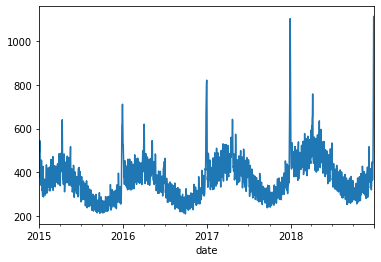

In [ ]:
df_all_groups[1].num_sold.plot()

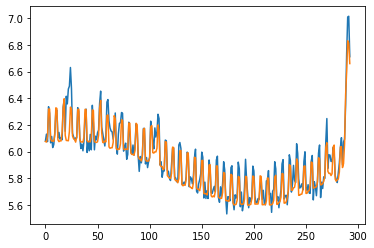

In [ ]:
plt.plot(range(0,y_test.size),y_test)
plt.plot(range(0,ts_pred.size),ts_pred)

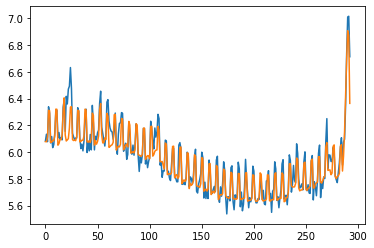

In [ ]:
plt.plot(range(0,y_test.size),y_test)
plt.plot(range(0,ts_pred.size),ts_pred)

In [ ]:
tr_pred = stack_gen.predict(X_train)
ts_pred = stack_gen.predict(X_test)
print(mean_squared_log_error(y_train,tr_pred))
print(mean_squared_log_error(y_test,ts_pred))

0.006794725207924846
0.008747810707216903


In [ ]:
data[1].columns[1:]

Index(['gdp', 'month', 'weekday', 'dayOfYear', '2_month', '3_month', 'week',
       'is_weekend', 'is_friday', 'fst_half_week', 'scd_half_week',
       'is_holiday_fin', 'is_holiday_nor', 'is_easter_1', 'is_easter_2',
       'year_mod2', 'total_holidays', 'is_holiday_fin_weekend', 'may_holiday',
       'is_christmas', 'season'],
      dtype='object')

In [ ]:
for i in range(18):
    features4scale = data[i].columns[1:]
    data[i][features4scale] = scaller.fit_transform(data[i][features4scale])
    data_test[i][features4scale] = scaller.transform(data_test[i][features4scale])

In [ ]:
model.get_params()['depth']
model.get_params()['iterations']
model.get_params()['l2_leaf_reg']
model.get_params()['learning_rate']
model.get_params()['loss_function']
model.get_params()['random_state']
model.get_params()['verbose']

{'depth': 3,
 'iterations': 120,
 'l2_leaf_reg': 5,
 'learning_rate': 0.5,
 'loss_function': 'MAE',
 'random_state': 79378,
 'verbose': False}

In [ ]:
stack_all = []
for d in data:
    model = CatBoostRegressor(
        random_state =79378,
        # n_estimators=3000,
        bootstrap_type='Bayesian',
        boosting_type='Plain',    
        loss_function = 'MAE',
        eval_metric = 'SMAPE',    
        verbose=False
        )
    grid = {'learning_rate': [0.5,0.55],
            'depth': [3],
            'l2_leaf_reg': [5],
            'n_estimators':[90,100,120]}
    model.grid_search(grid, 
                      X=X_train, 
                      y=y_train, 
                      verbose=False
                      )
    estimators = [
        ('CAT',CatBoostRegressor(
            depth = model.get_params()['depth'],
            iterations = model.get_params()['iterations'],
            l2_leaf_reg = model.get_params()['l2_leaf_reg'],
            learning_rate = model.get_params()['learning_rate'],
            loss_function = model.get_params()['loss_function'],
            random_state = model.get_params()['random_state'],
            verbose = model.get_params()['verbose']
        )),
        ('KernelR',KernelRidge()),
        ('MLP',MLPRegressor(
            hidden_layer_sizes=(36,12),
            alpha=1e-05,
            activation='relu',
            early_stopping=True,
            max_iter=20000,
            random_state=79378)),
        ('XGB',XGBRegressor(random_state=79378)),
        ('ElasticNET',ElasticNet(alpha=0, l1_ratio=0)),
        ('BAY',BayesianRidge()),
        ('SGD',SGDRegressor(random_state=79378)),
        ('SVR',SVR(C=10, gamma=0.1))
    ]
    # final_est = Ridge(alpha=0)
    # final_est = CatBoostRegressor(
    #                           loss_function='MAE',
    #                           random_seed = 123,
    #                           verbose=50)
    final_est = LinearRegression(positive=True)            
    stack = StackingRegressor(estimators,final_est,verbose=False)
    stack_all.append(stack.fit(d.drop(columns=['y'],axis=1), d.y))

In [ ]:
predictions = []
for model,d_test in zip(stack_all,data_test):
    predictions.append(model.predict(d_test.drop(columns=['y'],axis=1)))

In [ ]:
for pred, d_test in zip(predictions,df_all_groups_test):
    d_test['num_sold'] = pred

df_test_result = pd.concat([x for x in df_all_groups_test])    

In [ ]:
submition = df_test_result.sort_values(by='row_id')[['row_id','num_sold']].set_index('row_id')
submition.num_sold = np.exp(submition.num_sold)
# submition.num_sold = np.expm1(submition.num_sold)
submition.to_csv("submition_stack.csv")

In [ ]:
submition.num_sold

row_id
26298     411.412522
26299     603.212853
26300     174.853791
26301     725.798014
26302    1072.008980
            ...     
32863     848.757647
32864     229.013297
32865     857.632807
32866    1660.884489
32867     406.819504
Name: num_sold, Length: 6570, dtype: float64

In [ ]:
submition.num_sold

row_id
26298     405.859293
26299     606.364303
26300     176.801994
26301     631.045700
26302    1068.544608
            ...     
32863     803.273845
32864     215.098710
32865     969.211525
32866    1238.659814
32867     413.799082
Name: num_sold, Length: 6570, dtype: float64

In [ ]:
submition.num_sold

row_id
26298     346.794920
26299     541.757763
26300     157.201573
26301     633.430415
26302     949.380314
            ...     
32863     813.954890
32864     225.312838
32865     920.655507
32866    1485.831395
32867     374.052351
Name: num_sold, Length: 6570, dtype: float64

In [ ]:
submition.num_sold

row_id
26298     429.643724
26299     600.344746
26300     171.390604
26301     700.054520
26302    1025.710516
            ...     
32863     763.091130
32864     228.264855
32865     916.002895
32866    1380.550420
32867     377.471128
Name: num_sold, Length: 6570, dtype: float64

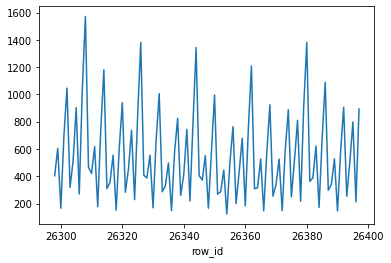

In [ ]:
submition.iloc[:100].num_sold.plot()

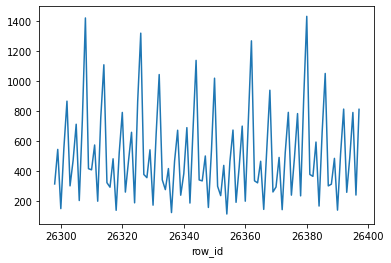

In [ ]:
submition.iloc[:100].num_sold.plot()

## blending!

In [ ]:
df_cat_1 = pd.read_csv("/content/drive/MyDrive/datasets/tabular jan 22/submition_cat_14-1.csv") # 4.66770
df_cat_2 = pd.read_csv("/content/drive/MyDrive/datasets/tabular jan 22/submition_cat_14-2.csv") # 4.69801
df_cat_3 = pd.read_csv("/content/drive/MyDrive/datasets/tabular jan 22/submition_cat_15-1.csv") # 4.70678

df_stack_1 = pd.read_csv("/content/drive/MyDrive/datasets/tabular jan 22/submition_stack_14-3.csv") # 4.79708
df_stack_2 = pd.read_csv("/content/drive/MyDrive/datasets/tabular jan 22/submition_stack_15-1.csv") # 4.90348
df_stack_3 = pd.read_csv("/content/drive/MyDrive/datasets/tabular jan 22/submition_stack_15-2.csv") # 4.85861

In [ ]:
df_stack_14plt = df_stack_1.iloc[:100]
df_stack_24plt = df_stack_2.iloc[:100]
df_stack_34plt = df_stack_3.iloc[:100]

df_cat_14plt = df_cat_1.iloc[:100]
df_cat_24plt = df_cat_2.iloc[:100]
df_cat_34plt = df_cat_3.iloc[:100]

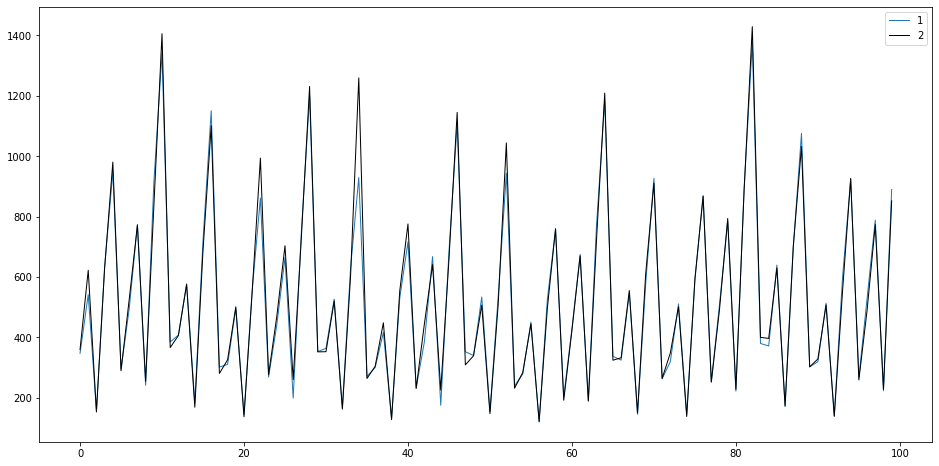

In [ ]:
fig = plt.figure(figsize=(16,8))
# plt.plot(range(0,df_stack_14plt.num_sold.size),df_stack_14plt.num_sold,linewidth=1)
# plt.plot(range(0,df_stack_24plt.num_sold.size),df_stack_24plt.num_sold,linewidth=1)
# plt.plot(range(0,df_stack_34plt.num_sold.size),df_stack_34plt.num_sold,linewidth=1)

plt.plot(range(0,df_cat_14plt.num_sold.size),df_cat_14plt.num_sold,linewidth=1)
# plt.plot(range(0,df_cat_24plt.num_sold.size),df_cat_24plt.num_sold,linewidth=1)
# plt.plot(range(0,df_cat_34plt.num_sold.size),df_cat_34plt.num_sold,linewidth=1)
# plt.plot(range(0,df_cat_34plt.num_sold.size),submition.iloc[:100].num_sold,linewidth=1)

plt.plot(range(0,100),submition.iloc[:100].num_sold,linewidth=1,c='black')
# fig = plt.figure(figsize=(16,8))
plt.legend(['1','2','3','new'])
# plt.legend(['new_stack','final_old','final_new'])

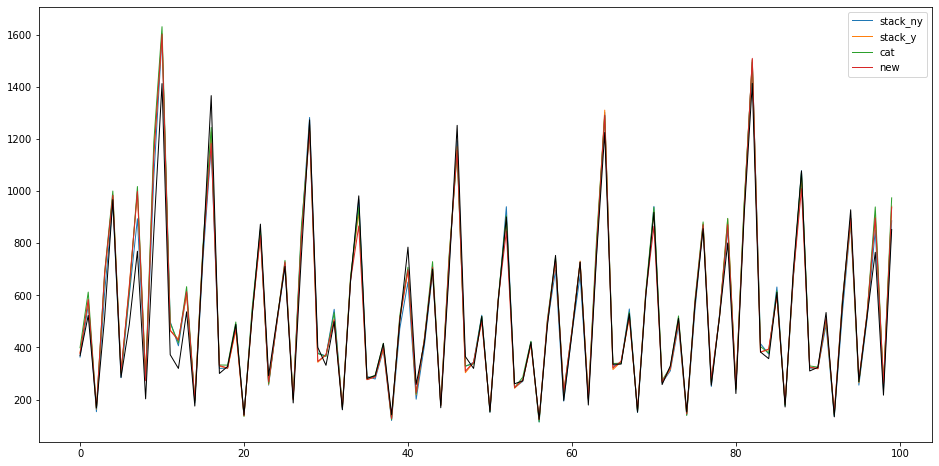

In [ ]:
fig = plt.figure(figsize=(16,8))
plt.plot(range(0,df_stack_14plt.num_sold.size),df_stack_14plt.num_sold,linewidth=1)
plt.plot(range(0,df_stack_24plt.num_sold.size),df_stack_24plt.num_sold,linewidth=1)
plt.plot(range(0,df_stack_34plt.num_sold.size),df_stack_34plt.num_sold,linewidth=1)
plt.plot(range(0,df_stack_44plt.num_sold.size),df_stack_44plt.num_sold,linewidth=1)
plt.plot(range(0,100),submition.iloc[:100].num_sold,linewidth=1,c='black')
# fig = plt.figure(figsize=(16,8))
plt.legend(['stack_ny','stack_y','cat','new'])
# plt.legend(['new_stack','final_old','final_new'])

In [ ]:
df_final = df_cat_1.copy()

In [ ]:
df_final.num_sold = (df_cat_1.num_sold*3 + \
                     df_cat_2.num_sold*2 + \
                     df_cat_3.num_sold*2 + \
                     df_stack_1.num_sold + \
                     df_stack_2.num_sold + \
                     df_stack_3.num_sold)/10 

In [ ]:
df_final.num_sold

0        377.771227
1        570.838363
2        163.674163
3        622.304765
4       1016.635764
           ...     
6565     774.160556
6566     227.167450
6567     898.718887
6568    1528.895957
6569     370.383744
Name: num_sold, Length: 6570, dtype: float64

In [ ]:
# df_final['sub_1'] = df_cat_1.num_sold
df_final['sub_1'] = df_stack_1.num_sold
df_final['sub_2'] = df_stack_2.num_sold
df_final['sub_3'] = df_stack_3.num_sold
df_final['sub_4'] = df_cat_1.num_sold
df_final['sub_5'] = df_cat_2.num_sold
df_final['sub_6'] = df_cat_3.num_sold

In [ ]:
df_final

,row_id,num_sold,sub_1,sub_2,sub_3,sub_4,sub_5,sub_6
0,26298,377.771227,388.904060,404.207747,411.412522,346.794920,368.103466,398.298125
1,26299,570.838363,569.936118,604.847848,603.212853,541.757763,522.634051,629.922709
2,26300,163.674163,171.685365,165.989790,174.853791,157.201573,167.807764,158.496219
3,26301,622.304765,672.694968,691.191221,725.798014,633.430415,515.257187,601.278915
4,26302,1016.635764,1029.905377,1046.247119,1072.008980,949.380314,967.085029,1117.942583
...,...,...,...,...,...,...,...,...
6565,32863,774.160556,794.079154,747.225396,848.757647,813.954890,559.664906,895.174441
6566,32864,227.167450,233.316682,237.911407,229.013297,225.312838,220.519109,227.228191
6567,32865,898.718887,938.328361,983.205232,857.632807,920.655507,1033.189321,689.838653
6568,32866,1528.895957,1222.321812,1350.568412,1660.884489,1485.831395,1465.400152,1833.445184


In [ ]:
df_final['sub_median'] = df_final[['sub_1','sub_2','sub_3','sub_4','sub_5','sub_6']].median(axis=1)

In [ ]:
df_final.tail()

,row_id,num_sold,sub_1,sub_2,sub_3,sub_4,sub_5,sub_6,sub_median
6565,32863,774.160556,794.079154,747.225396,848.757647,813.954890,559.664906,895.174441,804.017022
6566,32864,227.167450,233.316682,237.911407,229.013297,225.312838,220.519109,227.228191,228.120744
6567,32865,898.718887,938.328361,983.205232,857.632807,920.655507,1033.189321,689.838653,929.491934
6568,32866,1528.895957,1222.321812,1350.568412,1660.884489,1485.831395,1465.400152,1833.445184,1475.615773
6569,32867,370.383744,348.009977,412.396655,406.819504,374.052351,322.302783,384.924340,379.488345


In [ ]:
submition.num_sold.tail()

row_id
32863     730.363509
32864     240.117873
32865     859.285351
32866    1705.629577
32867     357.814136
Name: num_sold, dtype: float64

In [ ]:
df_final.num_sold = df_final.sub_median

In [ ]:
df_final[['row_id','sub_median']].rename(columns={'sub_median':'num_sold'}).to_csv("blending.csv",index=False)

In [ ]:
df_final[['row_id','num_sold']].to_csv("blending.csv",index=False)